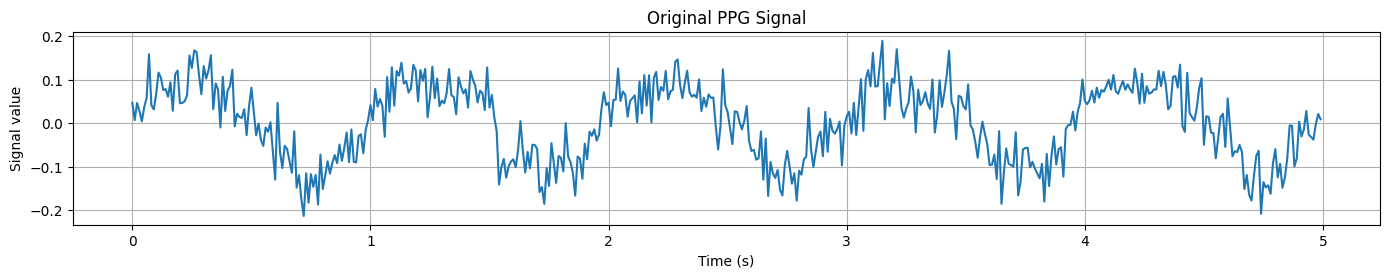

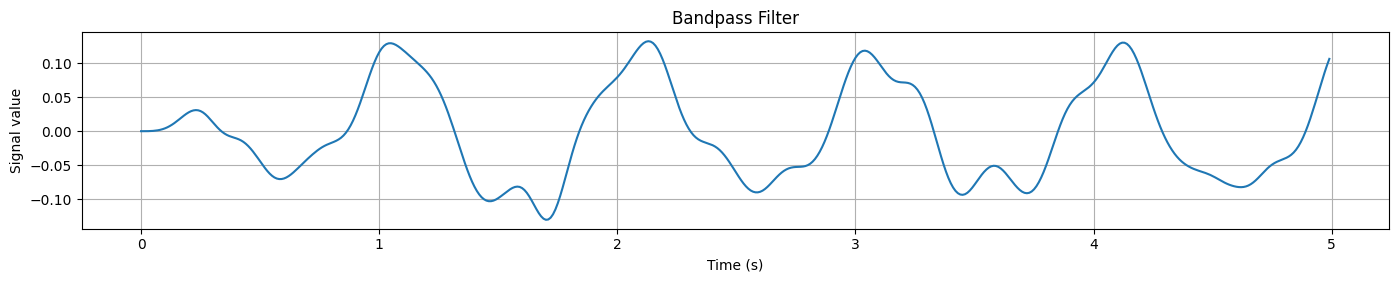

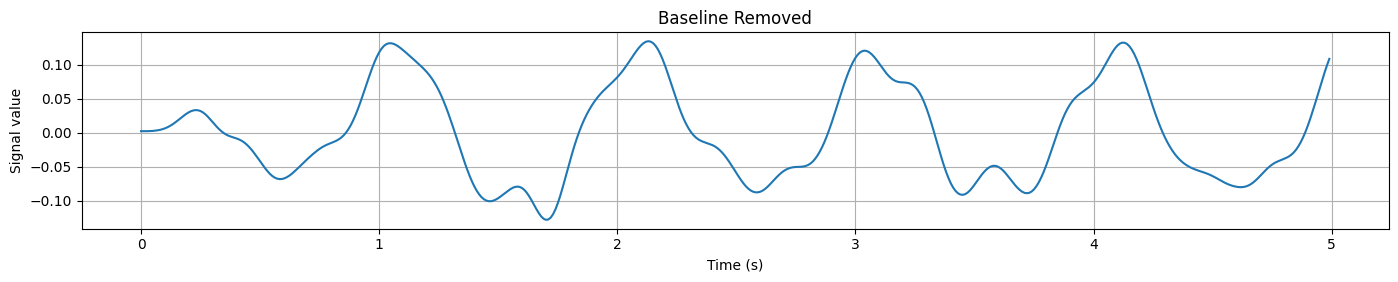

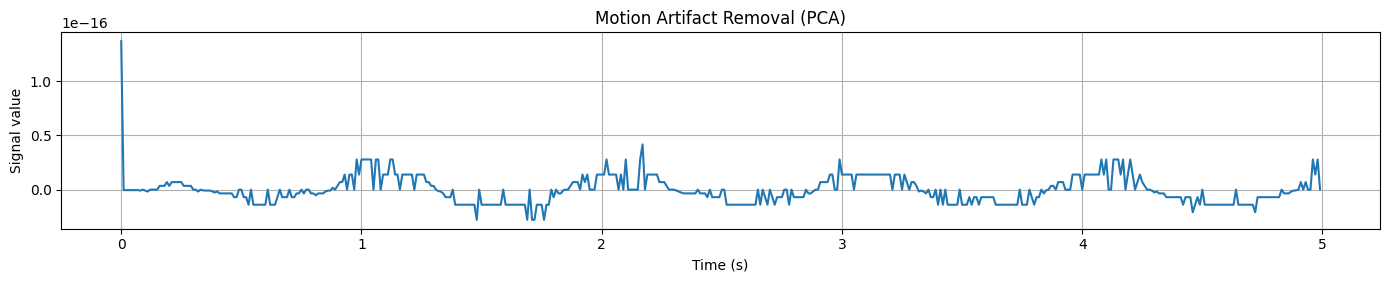

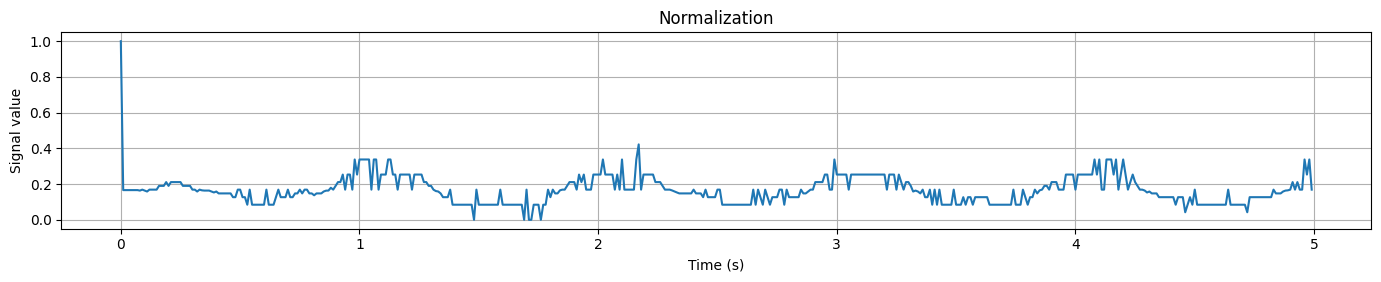

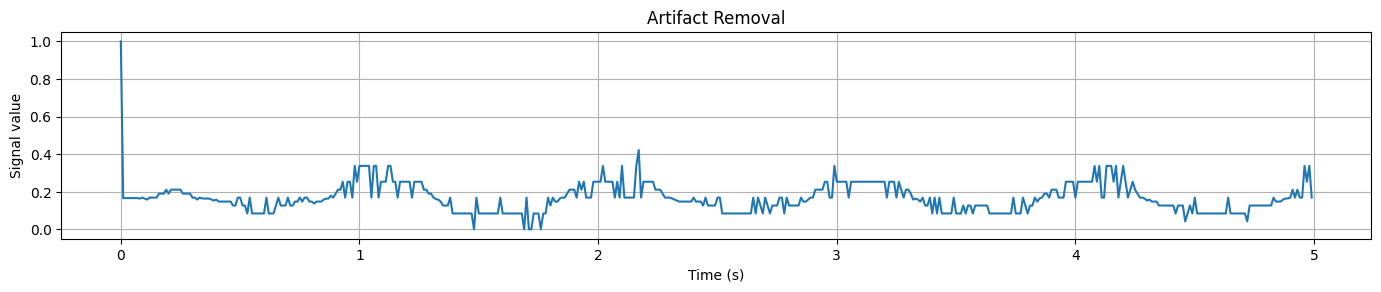

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, detrend, resample, find_peaks
from sklearn.decomposition import PCA

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def baseline(y):
    return np.mean(y)

def motion_removal(y):
    pca = PCA(n_components=1)
    y = y.reshape(-1, 1)
    principalComponents = pca.fit_transform(y)
    motion_removed = y - principalComponents
    return motion_removed.ravel()

def normalization(y):
    return (y - np.min(y)) / (np.max(y) - np.min(y))

def assess_quality(y):
    return []

def artifact_removal(y, segments_to_discard):
    return y

def detect_heartbeats(y):
    peaks, _ = find_peaks(y, distance=50) # adjust this distance accordingly
    return peaks

def preprocess_ppg_signal(x, fs, target_sampling_rate):
    results = {}

    y = bandpass_filter(x, 0.5, 4.0, fs)
    results['bandpass_filter'] = y.copy()

    y = y - baseline(y)
    results['baseline_removed'] = y.copy()

    y = motion_removal(y)
    results['motion_removed'] = y.copy()

    y = normalization(y)
    results['normalized'] = y.copy()

    y = resample(y, int(len(y) * target_sampling_rate/fs))

    segments_to_discard = assess_quality(y)
    y = artifact_removal(y, segments_to_discard)
    results['artifact_removed'] = y.copy()

    heartbeats = detect_heartbeats(y)
    results['heartbeats'] = heartbeats

    return y, results

# Using the same example PPG signal generation as before
fs = 100.0  # sample rate in Hz
T = 5.0    # seconds
n = int(T * fs)  # total number of samples
t = np.linspace(0, T, n, endpoint=False)
a = 0.02
f0 = 1.0
x = 0.1 * np.sin(2 * np.pi * 1.0 * t)
x += a * np.cos(2 * np.pi * 2.0 * t + .1)
x += a * np.cos(2 * np.pi * 3.5 * t)
x += 0.04 * np.random.randn(t.size)

processed_signal, results = preprocess_ppg_signal(x, fs, 100.0)

# Plotting


plot_titles = ["Original PPG Signal", "Bandpass Filter", "Baseline Removed",
               "Motion Artifact Removal (PCA)", "Normalization", "Artifact Removal"]
plot_data = [x, results['bandpass_filter'], results['baseline_removed'],
             results['motion_removed'], results['normalized'], results['artifact_removed']]

for i, (title, data) in enumerate(zip(plot_titles, plot_data), 1):
    plt.figure(figsize=(14, 15))
    plt.subplot(len(plot_titles), 1, i)
    plt.plot(t, data)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Signal value')
    plt.tight_layout()
    plt.grid()
    plt.show()
